In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'telco-customer-churn:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F13996%2F18858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240227%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240227T080346Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4204516cb56373435f7391c569cff247769a206f280df71bde58744bd2b48db56555341845dfb618a3b70ef34d56bfda37334efbfa35911a92413c0b0e0db401ee204ca2ab6ef11e0e83b5fab2fbe71ffa4312e38af59df1779317db992327e65380a24854a37bf8d922f4b9c363f3baede321956a067abda1b6b75e2d7549f4cf1f925d93260504663e4fedf3d237e7b53ed4bc21f3e0e289b78395ceed9c2a1bf2b1d70deaa5ef0fe3ca1e75cd4e0a6925fe54e159385d92bdb5ca1cc028e6dba5761935d7dab628b203e010af9646ce09a10281adc2808143e10a46627ed2c230ba5c34fb0b9d54654f2e9bfd713ce83a1e5d749a3e5b598c1c3862d0614b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'

shutil.rmtree(KAGGLE_INPUT_PATH, ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, exist_ok=True)

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)

    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0

            while True:
                data = fileres.read(CHUNK_SIZE)
                if not data:
                    break

                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()

            with ZipFile(tfile) if filename.endswith('.zip') else tarfile.open(tfile.name) as archive:
                archive.extractall(destination_path)

            print(f'\nDownloaded and uncompressed: {directory}')

    except (HTTPError, OSError) as e:
        print(f'Failed to load {download_url} to path {destination_path}')

print('Data source import complete.')

[==================================================] 175758 bytes downloaded
Downloaded and uncompressed: telco-customer-churn
Data source import complete.


# Customer Churn Analysis



### **About Data**

1. **`CustomerID`**: A unique ID that identifies each customer.

2. **`Gender`**: The customer’s gender: (Male, Female)

3. **`Age`**: The customer’s current age, in years, at the time the fiscal quarter ended.

4. **`Senior Citizen`**: Indicates if the customer is 65 or older: (Yes, No)

5. **`Married (Partner)`**: Indicates if the customer is married: (Yes, No)

6. **`Dependents`**: Indicates if the customer lives with any dependents: (Yes, No)

7. **`Number of Dependents`**: Indicates the number of dependents that live with the customer.

8. **`Phone Service`**: Indicates if the customer subscribes to home phone service with the company: (Yes, No)

9. **`Multiple Lines`**: Indicates if the customer subscribes to multiple telephone lines with the company:(Yes, No)

10. **`Internet Service`**: Indicates if the customer subscribes to Internet service with the company: (DSL, Fiber Optic)

11. **`Online Security`**: Indicates if the customer subscribes to an additional online security service provided by the company: (Yes, No)

12. **`Online Backup`**: Indicates if the customer subscribes to an additional online backup service provided by the company: (Yes, No)

13. **`Device Protection Plan`**: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: (Yes, No)

14. **`Premium Tech Support`**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: (Yes, No)

15. **`Streaming TV`**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: (Yes, No) The company does not charge an additional fee for this service.

16. **`Streaming Movies`**: Indicates if the customer uses their Internet service to stream movies from a third party provider: (Yes, No) The company does not charge an additional fee for this service.

17. **`Contract`**: Indicates the customer’s current contract type: (Month-to-Month, One Year, Two Year)

18. **`Paperless Billing`**: Indicates if the customer has chosen paperless billing: (Yes, No)

19. **`Payment Method`**: Indicates how the customer pays their bill: (Bank Withdrawal, Credit Card, Mailed Check)

20. **`Monthly Charge`**: Indicates the customer’s current total monthly charge for all their services from the company.

21. **`Total Charges`**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

22. **`Tenure`**: Indicates the total amount of months that the customer has been with the company.

23. **`Churn`**: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Reference:
https://www.kaggle.com/blastchar/telco-customer-churn


## A) Dataset

Lets start by importing libraries that we shall need

In [6]:
#EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

#Model Building Libraries
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#Parameters for plots
rcParams['figure.figsize'] = 8,6
sns.set_style('darkgrid')
rcParams['axes.titlepad']=15
RB = ["#123ea6", "#e63707"]
sns.set_palette(RB)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


Loading the dataset

In [8]:
df_base= pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

Checking the head and attributes of the dataset

In [9]:
df_base.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
df_base.shape

(7043, 21)

In [11]:
df_base.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [12]:
df_base.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [13]:
df_base.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


We can conclude that:
1. 75% of the customers have tenure less than 55 months
2. The mean tenure is around 32 months
3. The mean monthly charges are roughly around 64.76 USD and 25% customers pay more than 89.85 USD


Text(0.5, 1.0, 'No of Churned Customers')

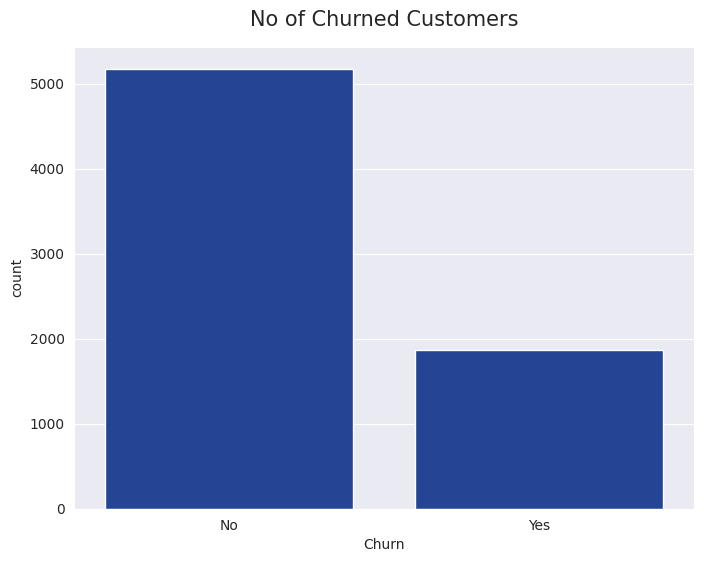

In [14]:
sns.countplot(x=df_base['Churn'])
plt.title('No of Churned Customers',fontsize=15)

In [15]:
df_base['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

As the distribution of data is not around 50:50 we can say that it is an 'Imbalanced Dataset'

Now lets check if any missing values exist in our dataset

In [16]:
df_base.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Seems like there are no missing values here.... But wait theres a catch!!!

We can see that majority of the columns are of datatype objects. Hence we should convert them into either float or integer values to really know if any null values exist. We can use the to_numeric method to do so.

In [18]:
df= df_base.copy()
df['TotalCharges']=pd.to_numeric(df_base['TotalCharges'],errors='coerce') #coerce puts NaN values if there are any parsing errors
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

As we can see now there are 11 missing values from the TotalCharges colums. Lets check these records

In [19]:
df[df.isnull().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


As we can see from the above dataframe the customers who have tenure equal to 0 are the ones with blank values in the TotalCharges column. Lets quickly check the dataframe where the tenure is 0

In [20]:
df[df['tenure']==0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


As both the dataframes match we can conclude that values are missing due to the fact that the customer has not yet paid anything to the company as they are new and hence none of them churned yet.

Since the percentage of these records compared to the dataset is very low (~0.156%), it is safe to drop them as they wont have a very large impact.

In [21]:
#Dropping the null values
df.dropna(inplace=True)

In [22]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [24]:
df1=df.copy()

df1.drop(['customerID'],axis=1,inplace=True)
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Tenure is a specific number and to visualize them would be difficult. Hence we will divide them into bins and assign them into groups. For e.g. tenure < 12 months then assign a group of 1-12 months as 0-1 years, for 13-24 assign group as between 1-2 years and so on...




In [25]:
df['tenure'].max() #The max tenure is 72 months or 6 years

72

In [26]:
# Group the tenures in bins of 12 months
labels = ["{0} - {1}".format(i,i+11) for i in range (1,72,12)]
df['tenure_group'] = pd.cut(df['tenure'], range(1,80,12), right=False, labels=labels)

In [27]:
df['tenure_group'].value_counts()

1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: tenure_group, dtype: int64

<Axes: xlabel='tenure_group', ylabel='count'>

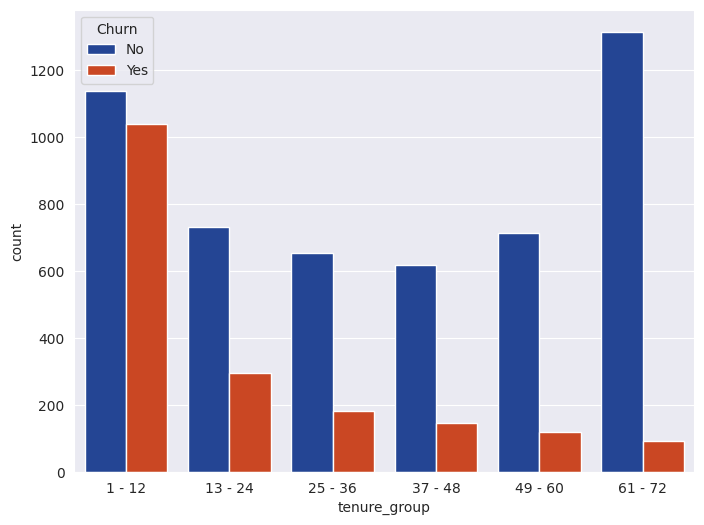

In [28]:
sns.countplot(x=df['tenure_group'],hue='Churn',data=df)

We can notice that customers who have tenure less than a year are the ones who are most likely to churn whereas the clients who have been with the company the longest are very less likely to churn. Also the number of customers with a monthly tenure is higher than others.

Now, lets remove the tenure column now as we have already transformed it into tenure_group

Lets drop the tenure and customerID columns as it is not of much use for data analysis and model training

In [29]:
df.drop(['customerID','tenure'],axis=1,inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


## B) Exploratory Data Analysis

### Univariate Analysis

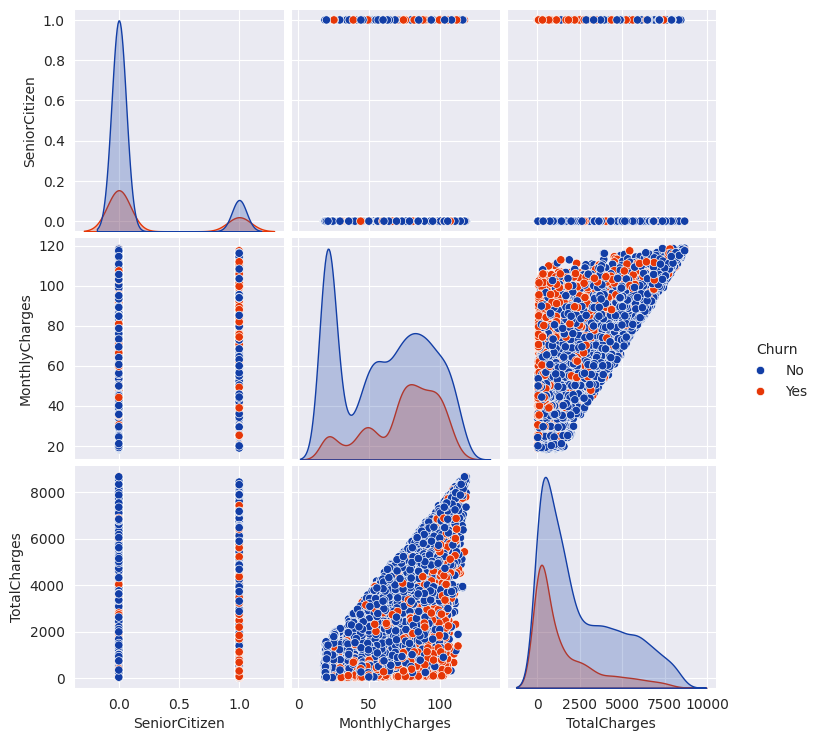

In [30]:
sns.pairplot(df,hue='Churn')

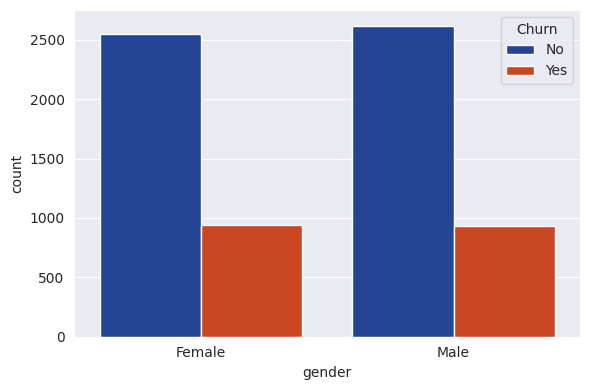

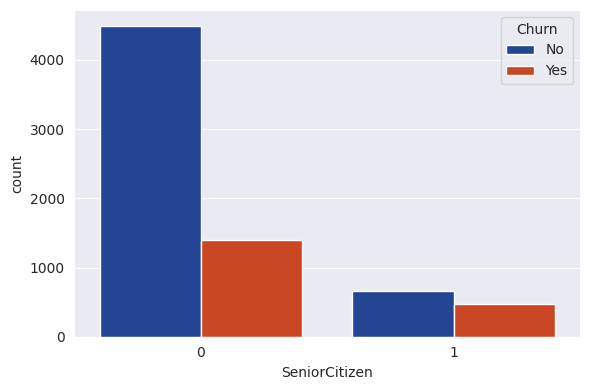

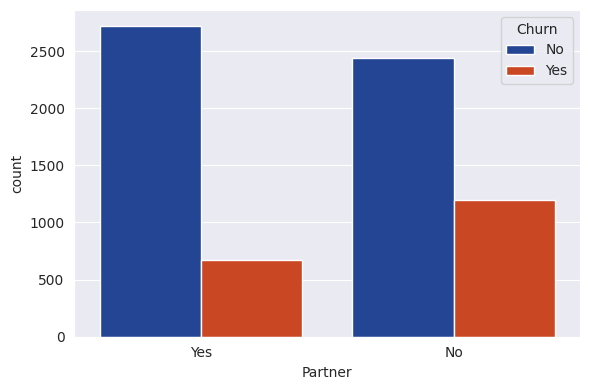

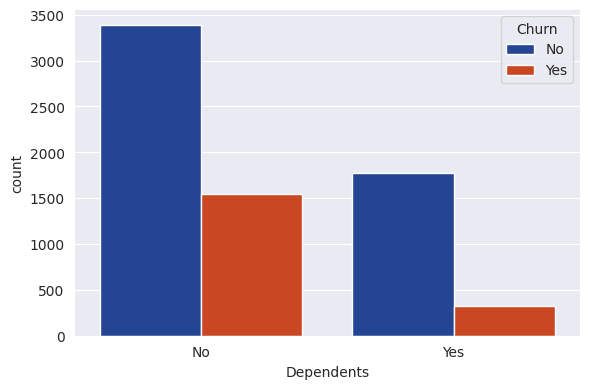

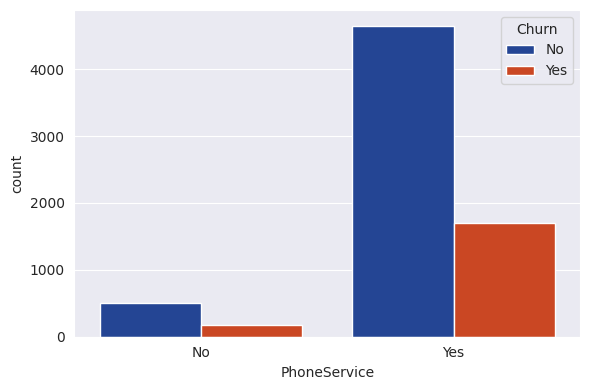

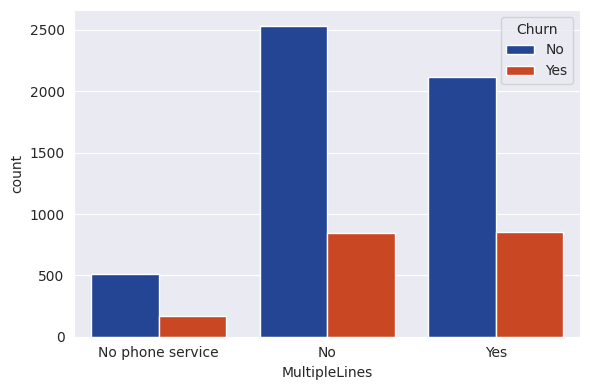

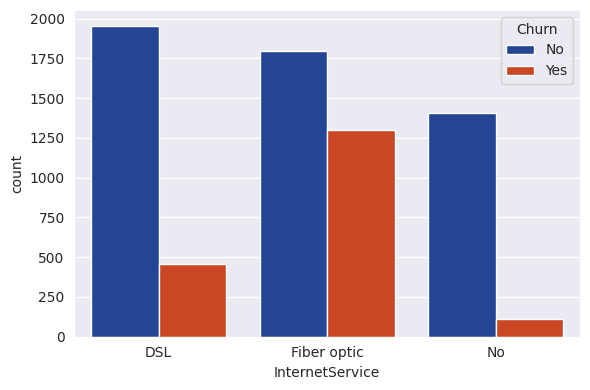

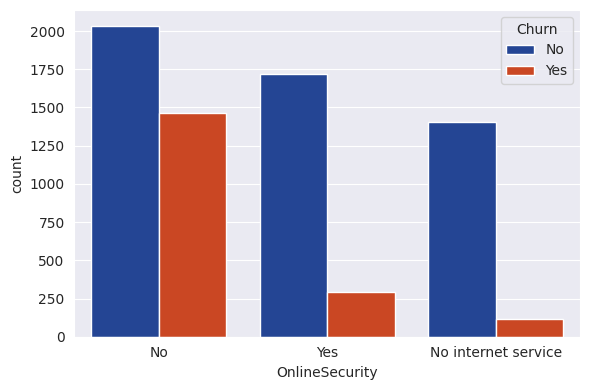

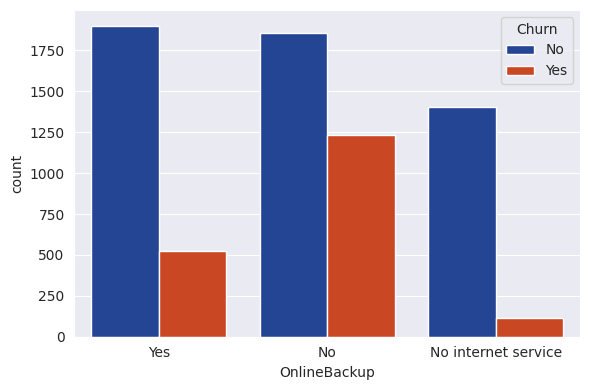

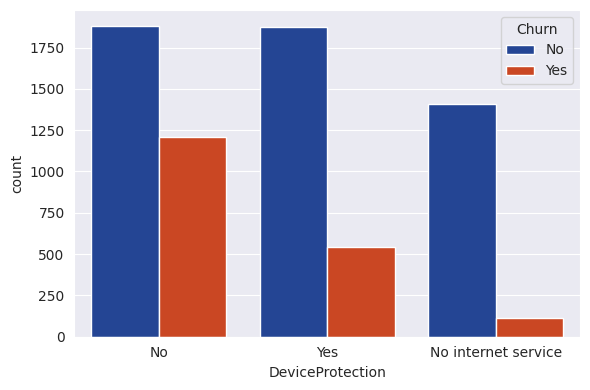

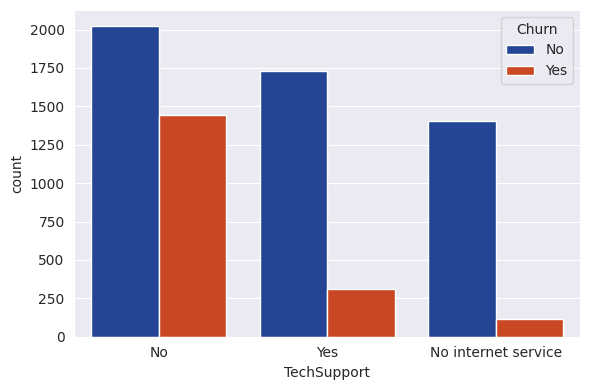

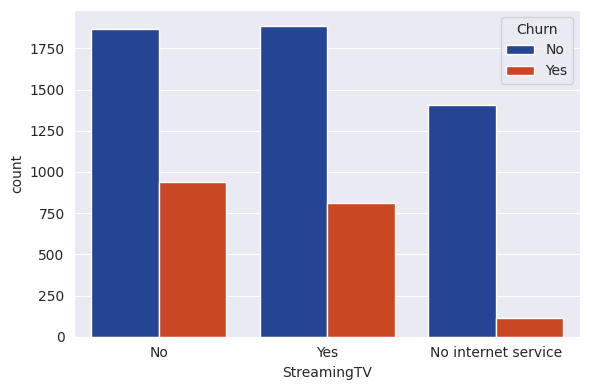

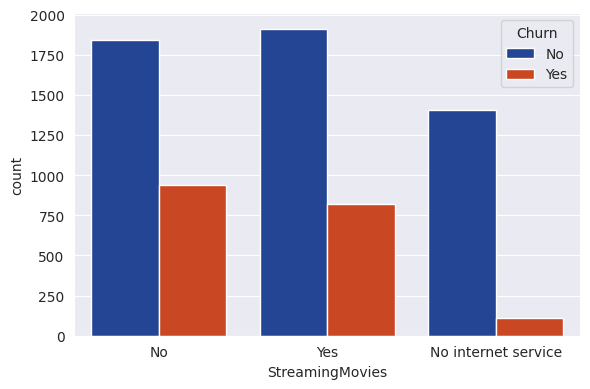

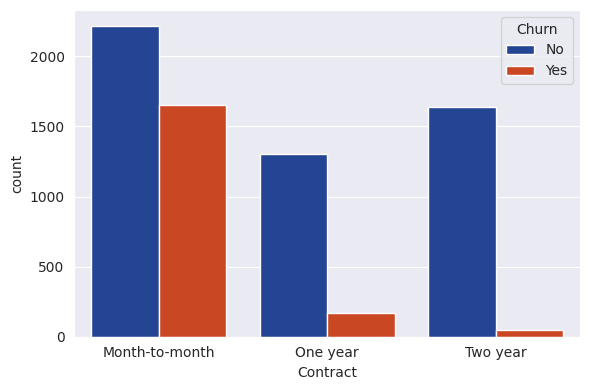

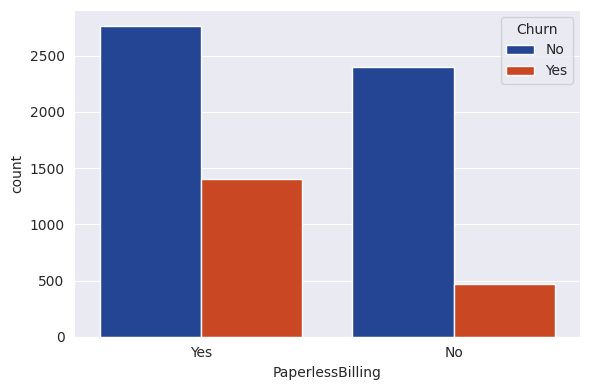

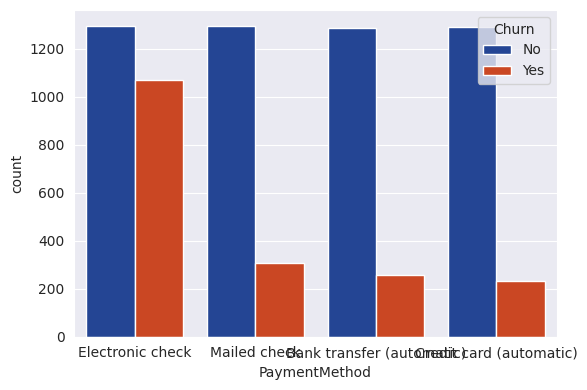

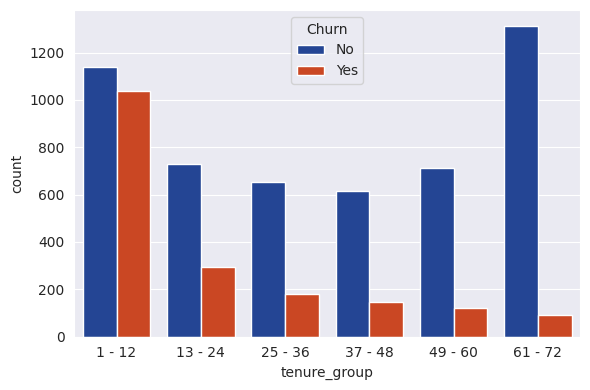

In [31]:
#Plotting the countplot of all important columns to gain insights
for i, predictor in enumerate(df.drop(columns=['Churn','TotalCharges','MonthlyCharges'])):
    plt.figure(i,figsize=(6,4))
    sns.countplot(data=df,x=predictor,hue='Churn')
    plt.tight_layout()

#### Observations:

1. **`Gender`** - The ratio is almost similar hence gender is not an important feature standalone but when combined will be of importance.
2. **`SeniorCitizen`** - Ratio of churners in Senior citizens is very high. If the customers are a Senior Citizen they are more likely to churn.
3. **`Partner`** - Customers with partners they are more likely to churn
4. **`Dependents`** - Customers with dependents they are less likely to churn
5. **`PhoneService`** - Customers with Phone Service are are more likely to churn
6. **`MultipleLines`** - Not much of an effect
7. **`InternetService`** Customers with Fiber optic as their service are more likely to churn probably due to high costs
8. **`OnlineSecurity`** Customers with Online Security are very less likely to churn than ones who dont have Online Security
9. **`OnlineBackup`** - Customers with OnlineBackup are less likely to churn
10. **`TechSupport`** - Customers with DeviceProtection are less likely to churn
11. **`StreamingTV/StreamingMovies`** - Not much of a effect as company doesn't charge an additional fee for these
12. **`Contract`** - Customers with contract of one year or more are very less likely to churn
12. **`PaperlessBilling`** - Not much of an effect
13. **`PaymentMethod`** - Customers who have paid through electronic check are very likely to churn and ones who paid through credit card are very less likely to churn
13. **`tenure_group`** - Customers who have tenure less than a year are the ones who are most likely to churn whereas the clients who have been with the company the longest are very less likely to churn

Now lets convert the target variable Churn into a binary numeric value i.e Yes=1, No=0

In [32]:
df['Churn'].replace(["Yes","No"], [1,0],inplace=True)

Let's also convert all the categorical variables into dummy variables

In [33]:
#One Hot Encoding
df_dummies = pd.get_dummies(df)
df_dummies.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108.15,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151.65,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [34]:
100*df[df['SeniorCitizen']==1].shape[0]/df.shape[0]

16.24004550625711

There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

Now lets check out the pairplot

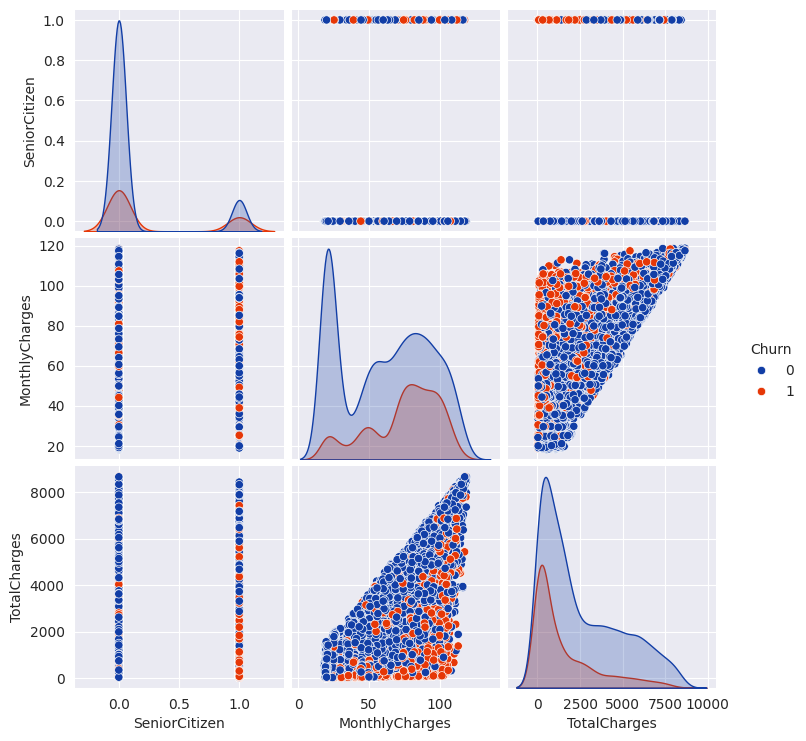

In [35]:
sns.pairplot(df,hue='Churn')

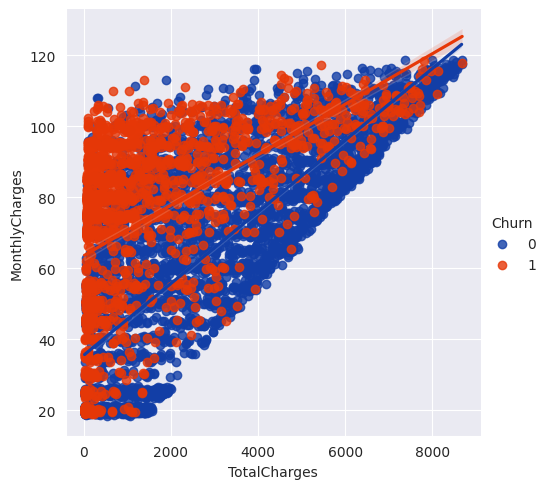

In [36]:
sns.lmplot(x='TotalCharges',y='MonthlyCharges',data=df,hue='Churn')

We can see that there is a relationship between MonthlyCharges and TotalCharges. TotalCharges Increases as Monthly Charges increases as expected. Now lets check out the kdeplot of MonthlyCharges and TotalCharges

<ipython-input-37-4d02cdf0a644>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_dummies,x='MonthlyCharges',hue='Churn',shade=True)


<Axes: xlabel='MonthlyCharges', ylabel='Density'>

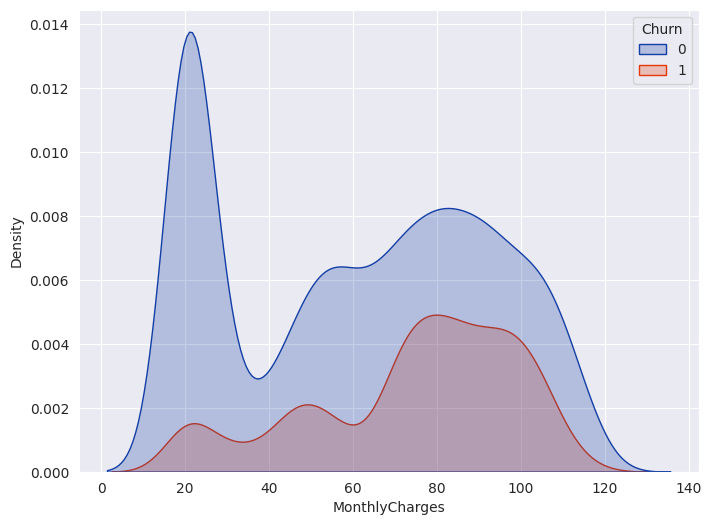

In [37]:
sns.kdeplot(data=df_dummies,x='MonthlyCharges',hue='Churn',shade=True)

<ipython-input-38-4a5e4f24e3f0>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_dummies,x='TotalCharges',hue='Churn',shade=True)


<Axes: xlabel='TotalCharges', ylabel='Density'>

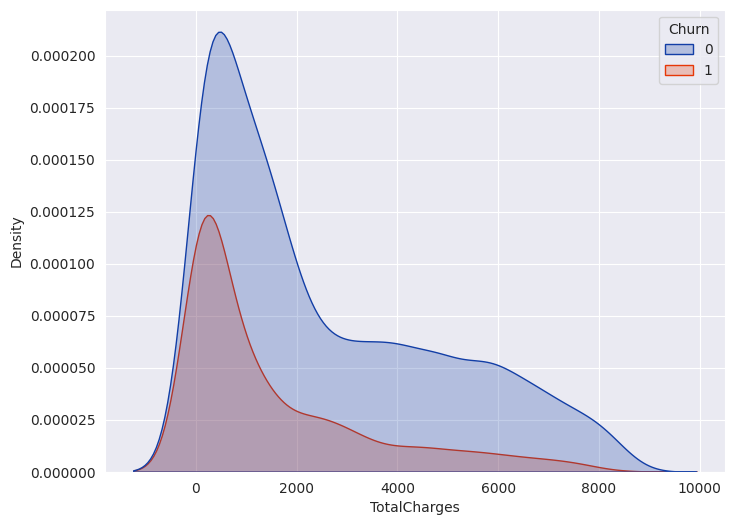

In [38]:
sns.kdeplot(data=df_dummies,x='TotalCharges',hue='Churn',shade=True)

We find that the Customers are more likely to churn for lower monthly and total charges...Why is that?


<ipython-input-39-5c3f771c42c5>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_dummies,x='MonthlyCharges',hue='tenure_group_1 - 12',shade=True)


<Axes: xlabel='MonthlyCharges', ylabel='Density'>

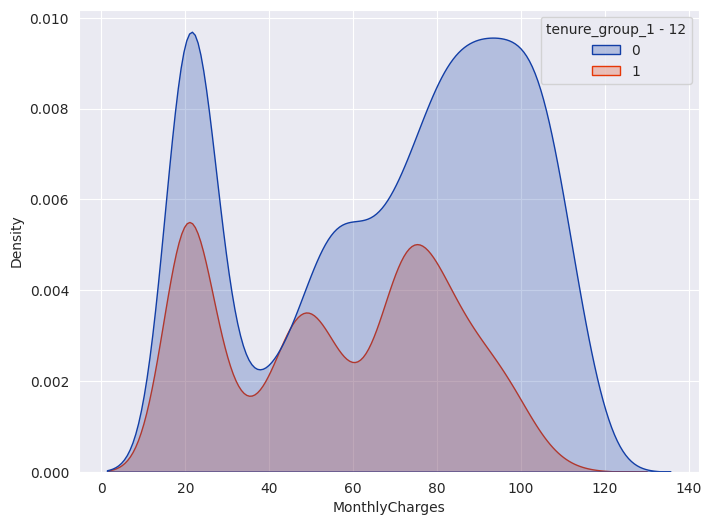

In [39]:
sns.kdeplot(data=df_dummies,x='MonthlyCharges',hue='tenure_group_1 - 12',shade=True)

<ipython-input-40-83bfc64a4e3e>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_dummies,x='TotalCharges',hue='tenure_group_1 - 12',shade=True)


<Axes: xlabel='TotalCharges', ylabel='Density'>

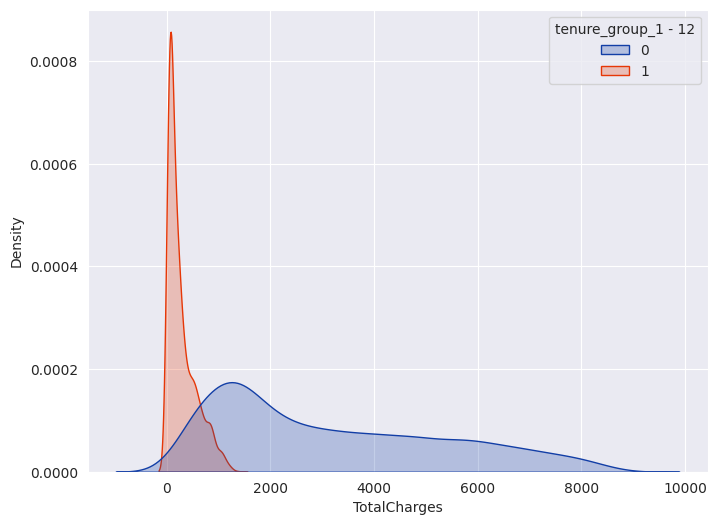

In [40]:
sns.kdeplot(data=df_dummies,x='TotalCharges',hue='tenure_group_1 - 12',shade=True)

We can see that people having a shorter tenure are the ones who are likely to churn and their Total charges will always be less due to their short tenures. Similarly, Low Monthly Charges users tend to churn becase they maybe trying the service and will churn if they find some other service
***

Lets see if the internet service plays a role in churning or not

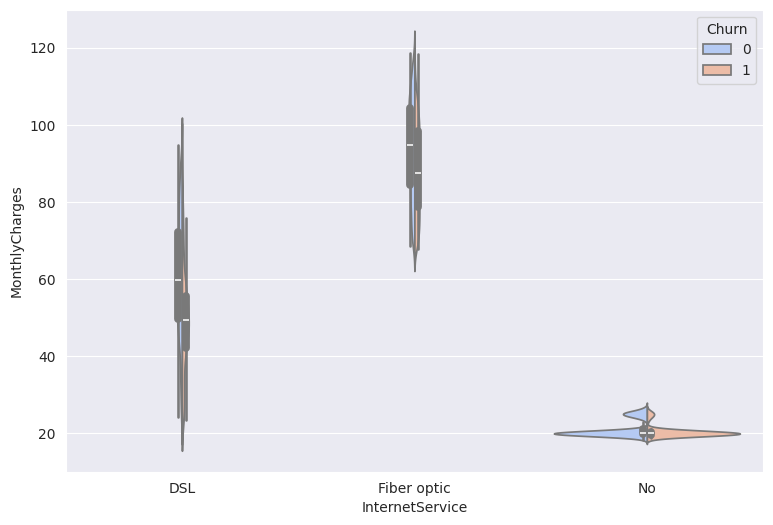

In [43]:
# Set the figure size
plt.figure(figsize=(9, 6))

# Create the violin plot
sns.violinplot(x="InternetService", y="MonthlyCharges", hue="Churn", split=True,
               palette="coolwarm", data=df)

# Show the plot
plt.show()

Customers with fiber optic (fast connection) are more probable to churn than those with DSL connection (slower connection) as their service.<br>
Also we can also observe that customers with DSL with higher charges are less probable to churn but the ones with lesser charges (~ 40-60 USD) are more likely to churn
***

Now Lets check the additional services offered by the company

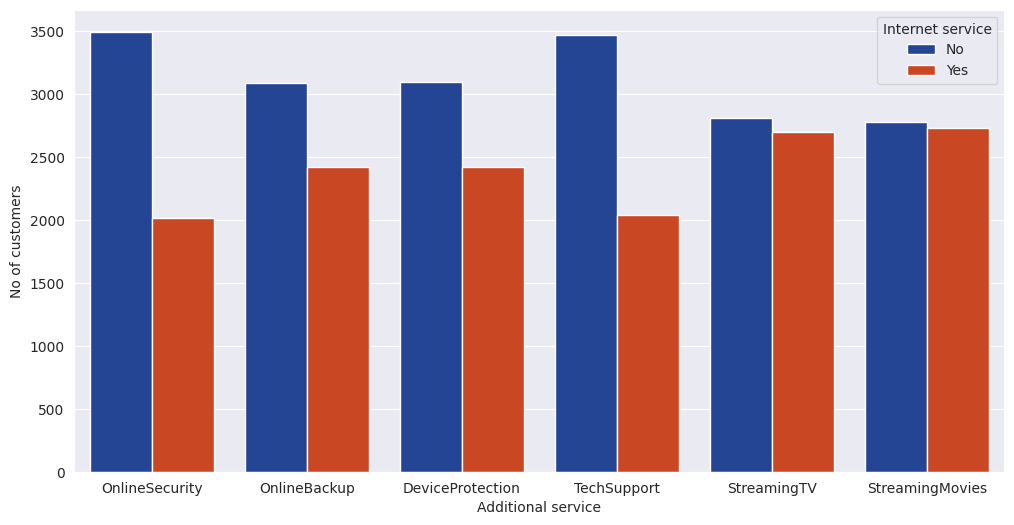

In [44]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df_service = pd.melt(df[df["InternetService"] != "No"][cols]).rename({'value': 'Internet service'}, axis=1)
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_service, x='variable', hue='Internet service')
ax.set(xlabel='Additional service', ylabel='No of customers')
plt.show()

Lets check the correlations of Churn with other features

Text(0.5, 1.0, 'Positive Correlation')

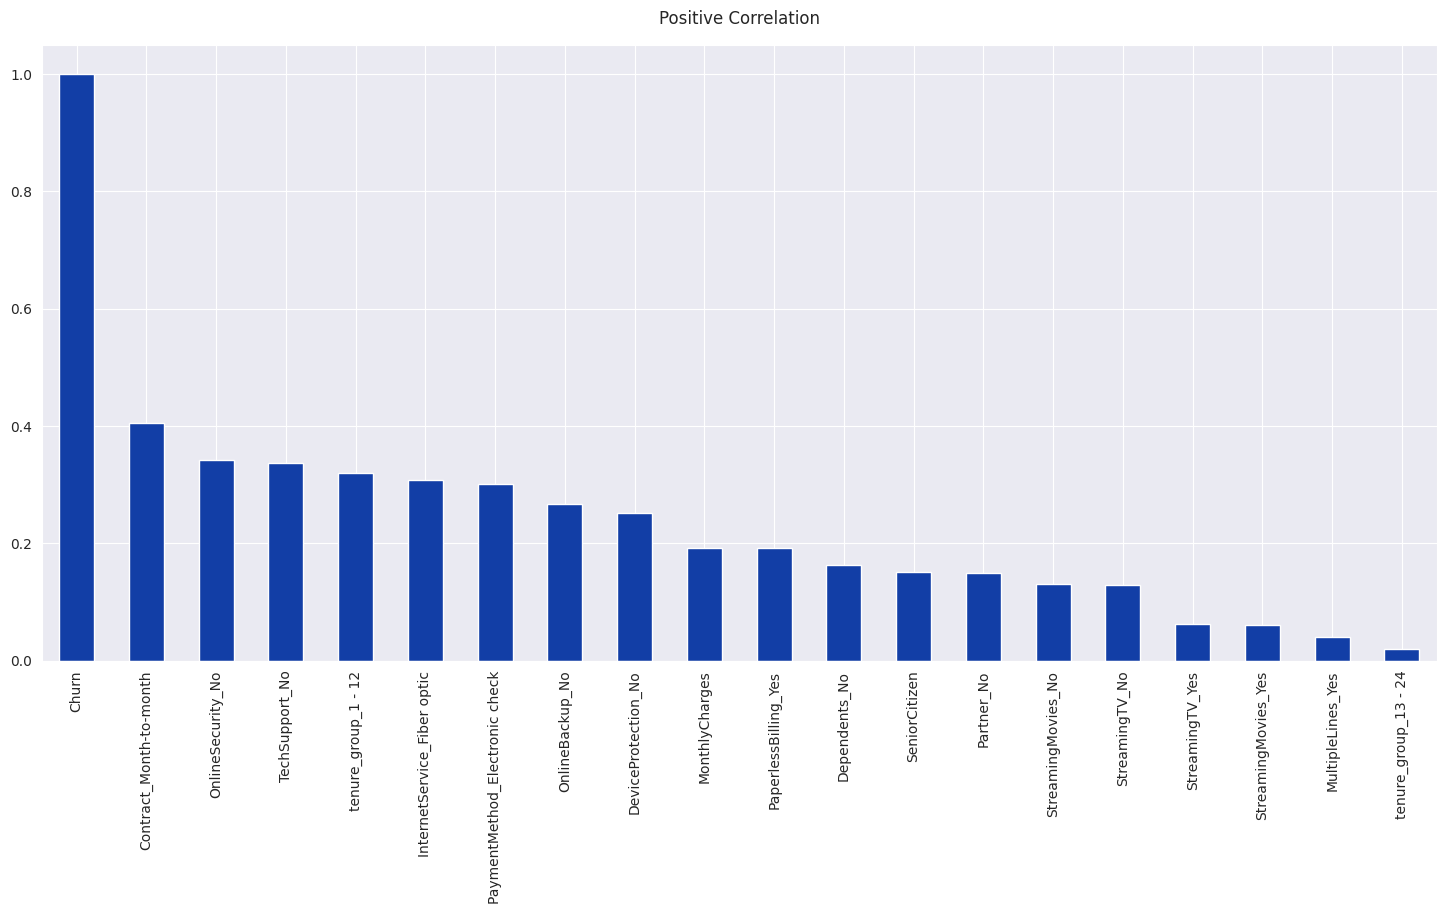

In [45]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(18,8))
df_dummies.corr()['Churn'].sort_values(ascending = False)[:20].plot(kind='bar')
plt.title('Positive Correlation')

Text(0.5, 1.0, 'Negative Correlation')

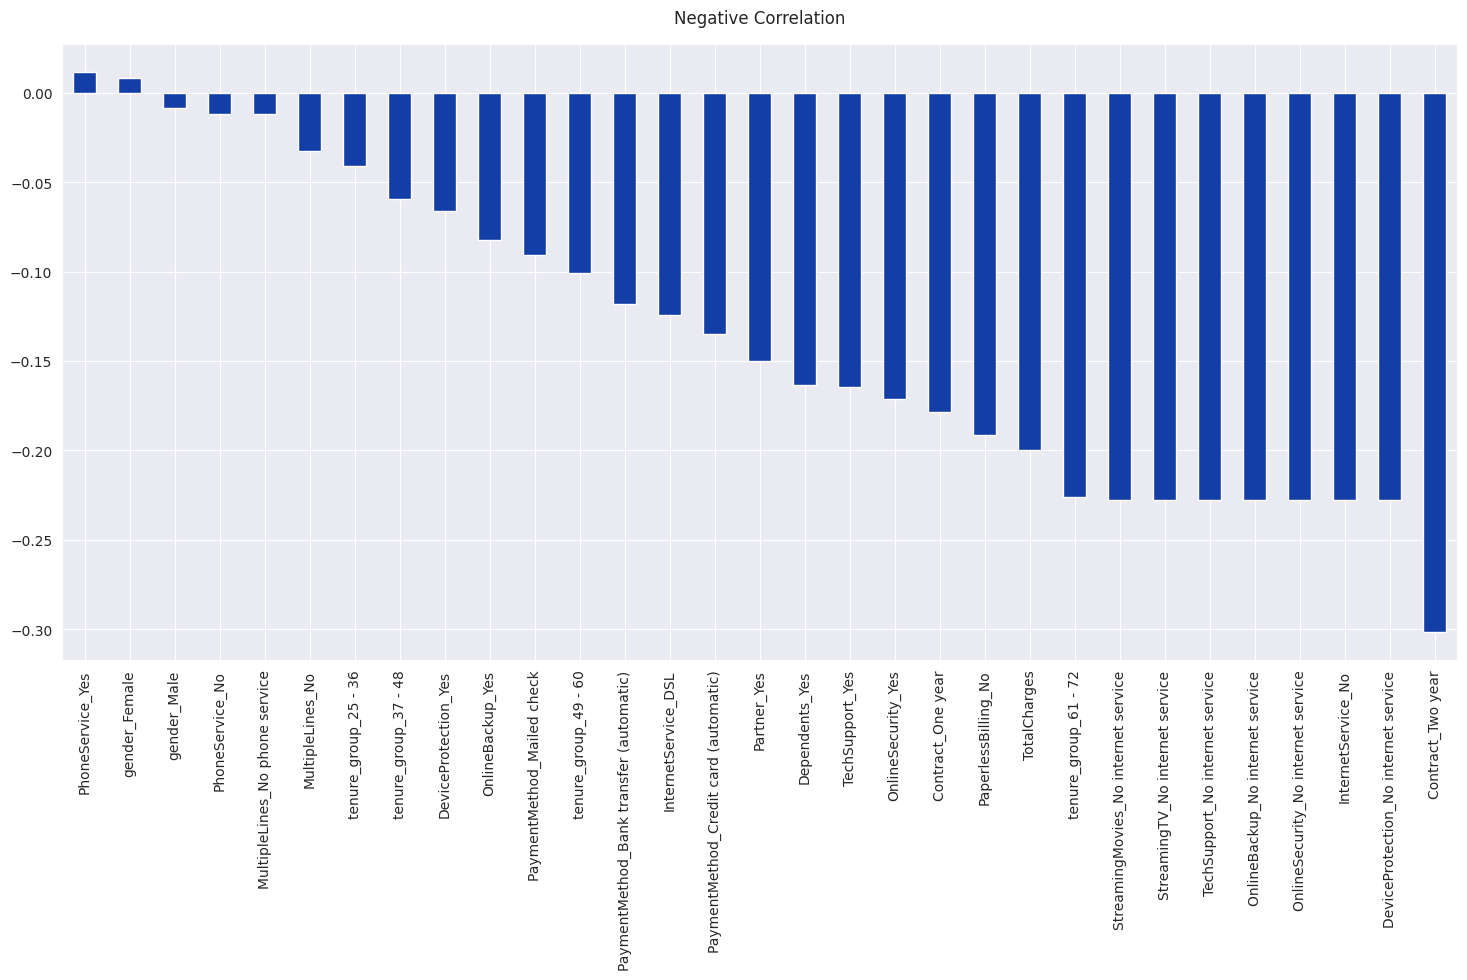

In [48]:
plt.figure(figsize=(18,8))
df_dummies.corr()['Churn'].sort_values(ascending = False)[20:].plot(kind='bar')
plt.title('Negative Correlation')

<Axes: >

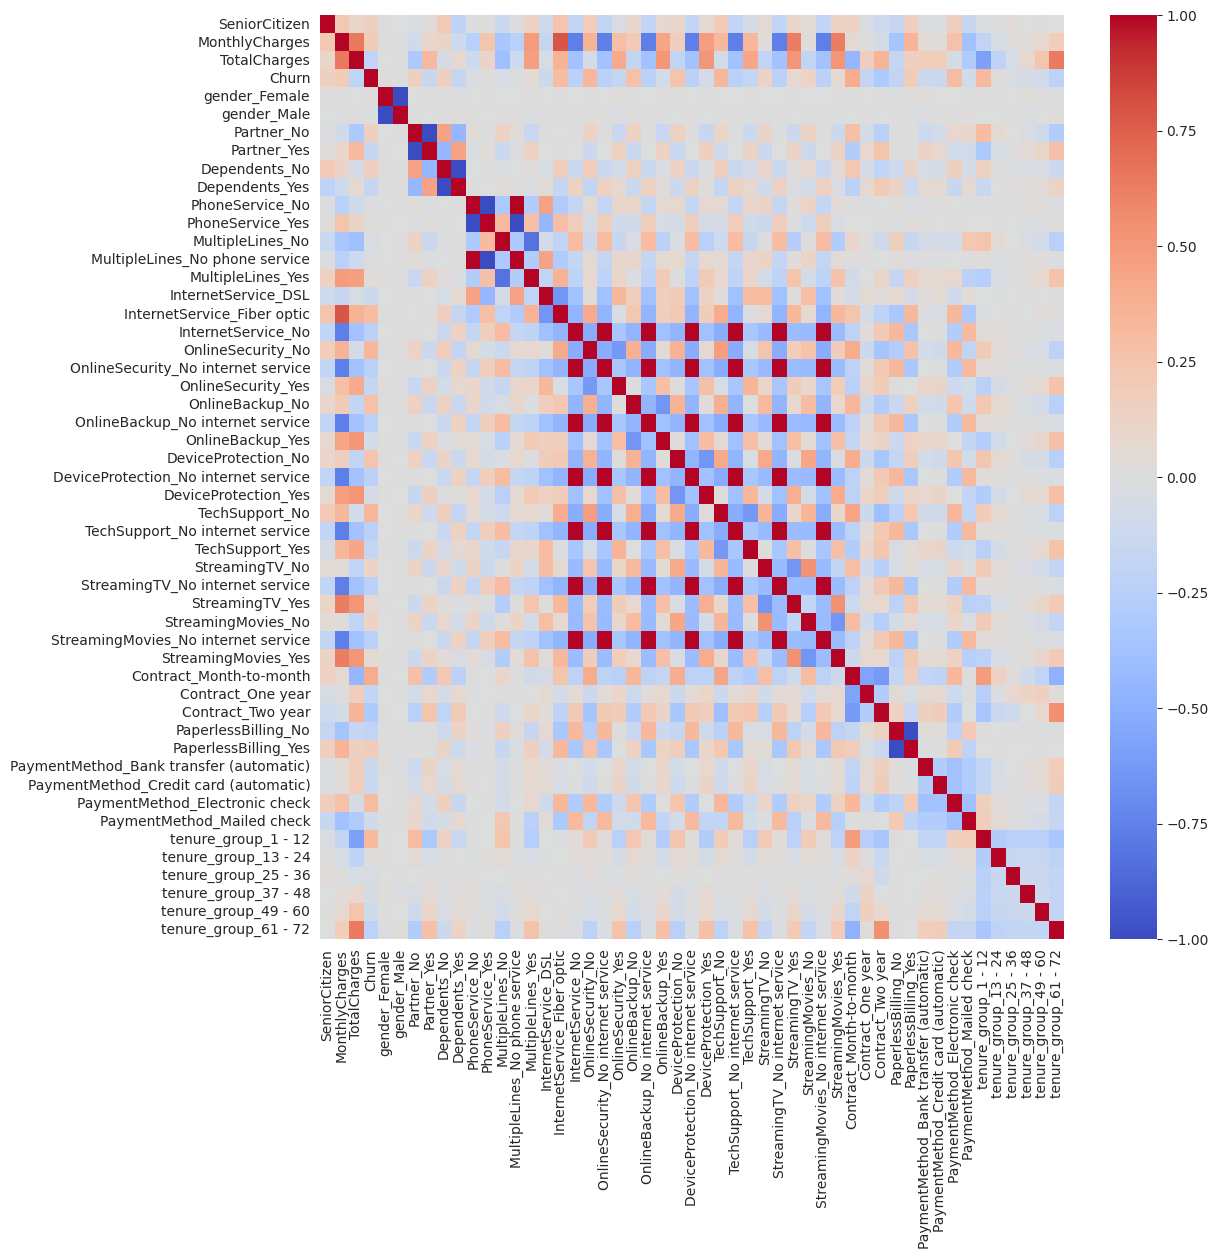

In [49]:
plt.figure(figsize=(12,12))
sns.heatmap(df_dummies.corr(),cmap='coolwarm')

### Bivariate Analysis

To do this lets seperate our database intro two categories- Churners and Non-Churners

In [50]:
churners_df = df.loc[df_dummies['Churn']==1]
non_churners_df = df.loc[df_dummies['Churn']==0]
churners_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12
5,Female,0,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,1 - 12
8,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,25 - 36
13,Male,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,49 - 60


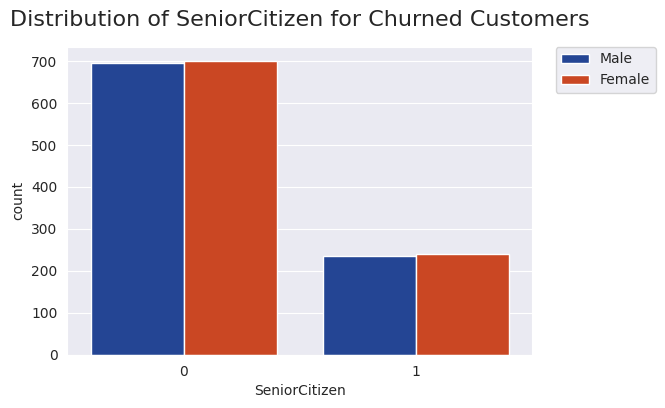

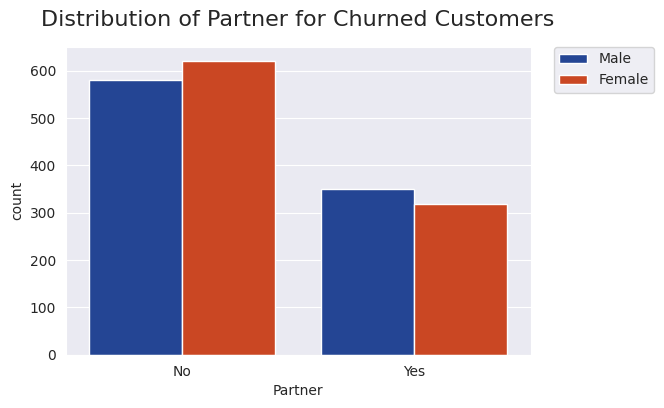

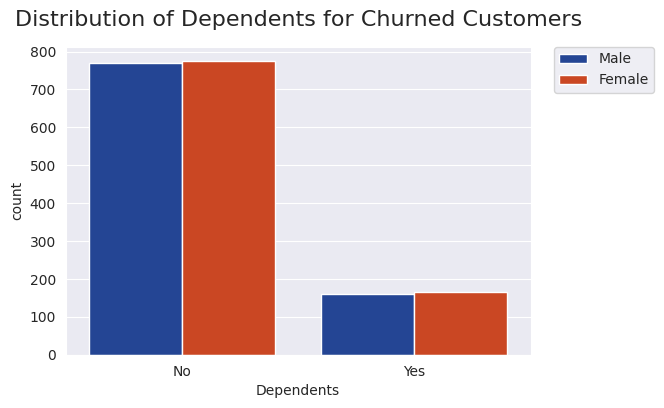

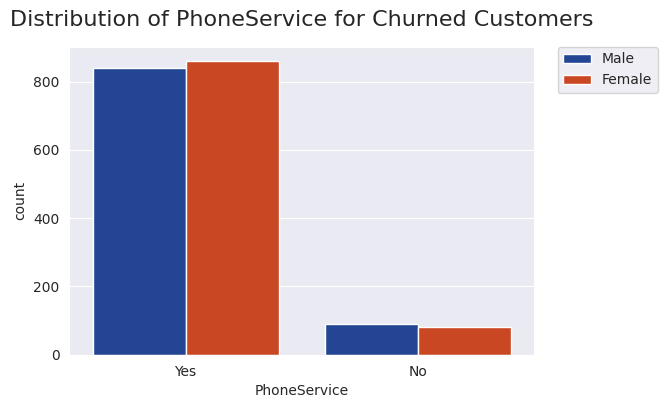

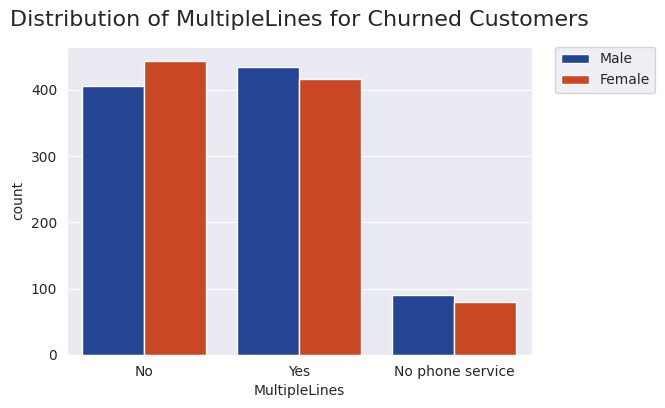

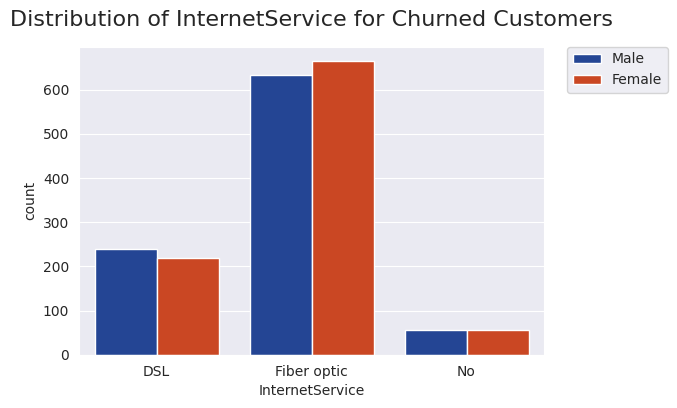

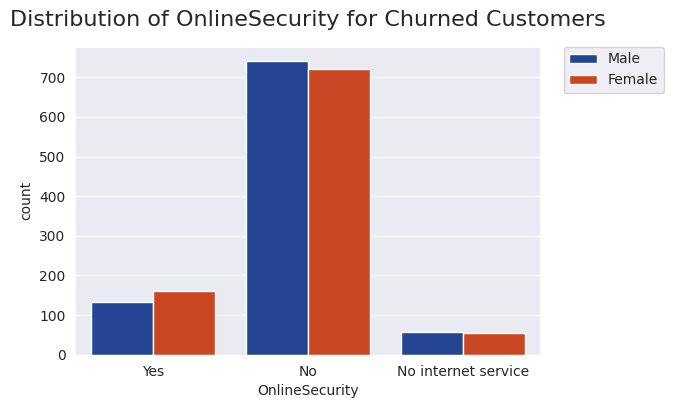

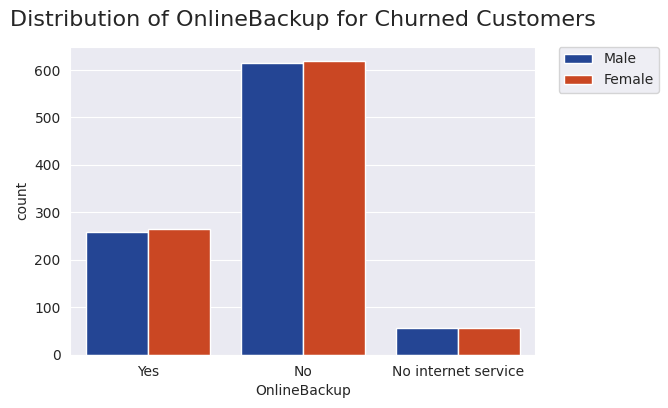

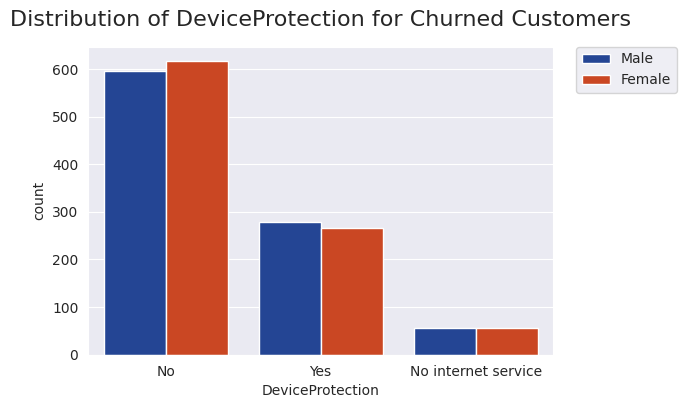

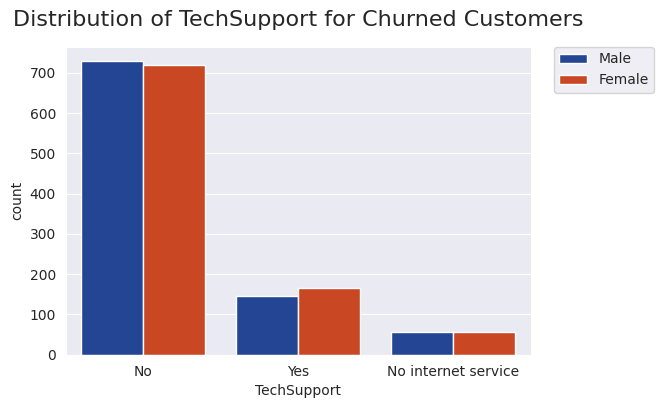

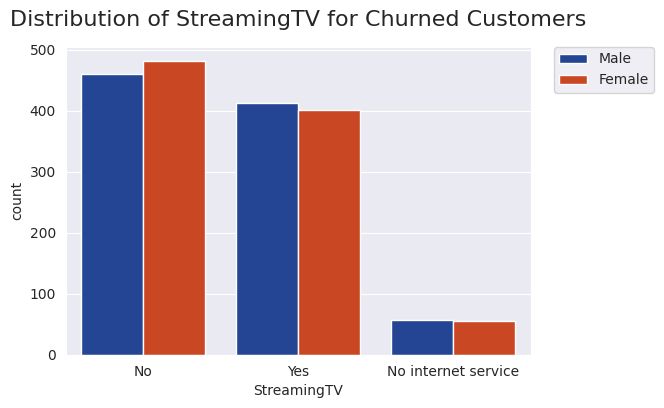

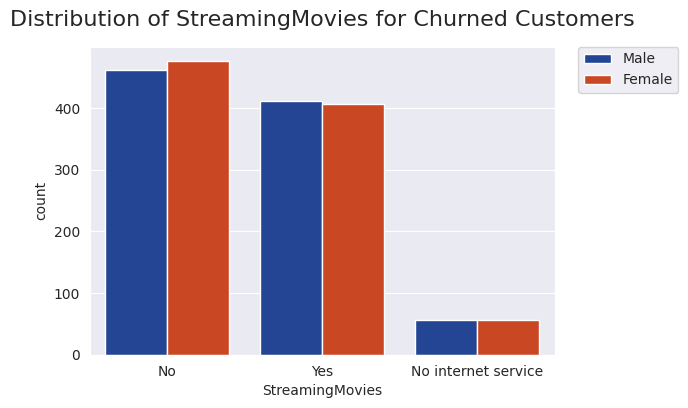

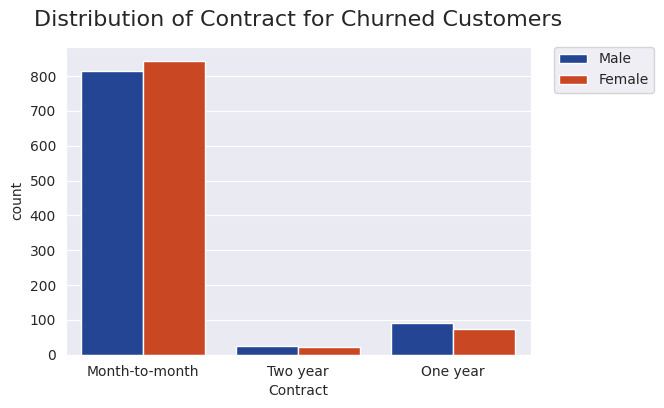

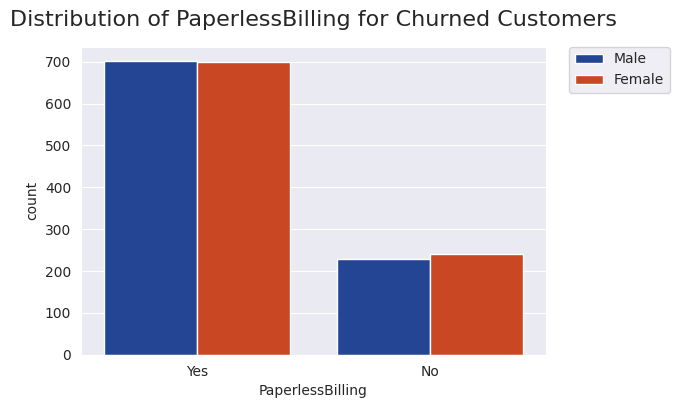

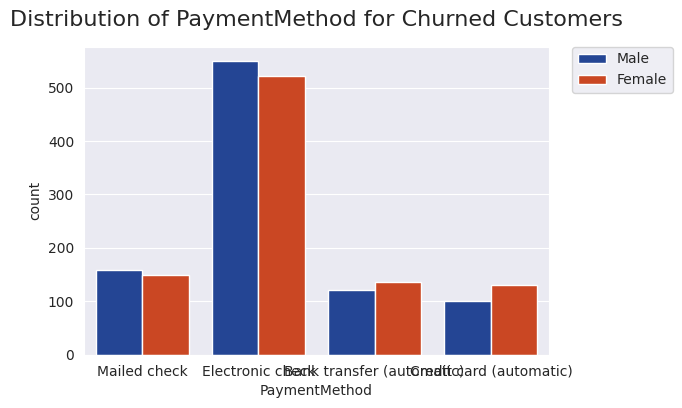

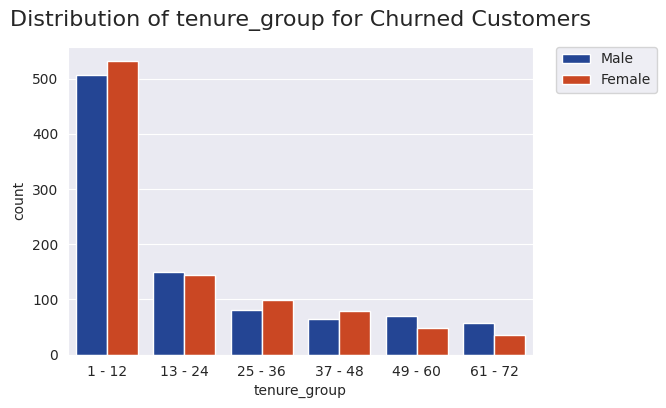

In [51]:
#Plotting the countplot of all important columns to gain insights


for i, predictor in enumerate(churners_df.drop(columns=['Churn','TotalCharges','MonthlyCharges','gender'])):
    plt.figure(i,figsize=(6,4))
    plt.title("Distribution of {} for Churned Customers".format(predictor),fontsize='16')
    sns.countplot(data=churners_df,x=predictor,hue='gender')
    plt.tight_layout
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## C) Training the Model to Predict Churning



In [53]:
df_base =  pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
replaceStruct = {"Churn":     {"No": 0, "Yes": 1 }  }
oneHotCols = ["gender","SeniorCitizen","Partner","Dependents","PhoneService","MultipleLines"
            ,"InternetService","OnlineSecurity","OnlineBackup",
            "DeviceProtection","TechSupport","StreamingTV","StreamingMovies",
            "Contract","PaperlessBilling","PaymentMethod"]

df2=df_base.replace(replaceStruct, inplace=True)
df2=pd.get_dummies(df_base, columns=oneHotCols)
pd.set_option('display.max_columns',100)
df2.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,34,56.95,1889.5,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [54]:
df2['TotalCharges']=pd.to_numeric(df_base['TotalCharges'],errors='coerce') #coerce puts NaN values if there are any parsing errors
df2.dropna(inplace=True)
df2=df2.drop('customerID',axis=1)
df2.to_csv(r'Telco-Customer-Predictions.csv')

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7032 non-null   int64  
 1   MonthlyCharges                           7032 non-null   float64
 2   TotalCharges                             7032 non-null   float64
 3   Churn                                    7032 non-null   int64  
 4   gender_Female                            7032 non-null   uint8  
 5   gender_Male                              7032 non-null   uint8  
 6   SeniorCitizen_0                          7032 non-null   uint8  
 7   SeniorCitizen_1                          7032 non-null   uint8  
 8   Partner_No                               7032 non-null   uint8  
 9   Partner_Yes                              7032 non-null   uint8  
 10  Dependents_No                            7032 no

In [56]:
df_dummies= pd.get_dummies(df2)
df_dummies

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,0,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1
7039,72,103.20,7362.90,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0
7040,11,29.60,346.45,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
7041,4,74.40,306.60,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1


In [57]:
X = df_dummies.drop('Churn',axis=1)
y = df_dummies['Churn']

### a) Decision Tree Classifier


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
dt_model = DecisionTreeClassifier(criterion='gini',max_depth=3, min_samples_leaf=8)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=8)

In [59]:
y_pred = dt_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
dt = round(accuracy_score(y_test, y_pred)*100, 2)
dt

77.33

In [61]:
def print_report(model,X_test,y_test,y_pred):
    """
    returns the model score, confusion matrix and classfication report
    """
    print("Model Score : {} \n ".format(model.score(X_test, y_test)))
    print("Confusion Matrix : \n {}\n".format(confusion_matrix(y_test,y_pred)))
    print("Accuracy : {}".format( round(accuracy_score(y_test, y_pred)*100, 2)))
    print("Classification report : \n\n"+classification_report(y_test, y_pred, labels=[0,1]))


In [62]:
print_report(dt_model,X_test,y_test,y_pred)

Model Score : 0.7732764747690121 
 
Confusion Matrix : 
 [[944  65]
 [254 144]]

Accuracy : 77.33
Classification report : 

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1009
           1       0.69      0.36      0.47       398

    accuracy                           0.77      1407
   macro avg       0.74      0.65      0.66      1407
weighted avg       0.76      0.77      0.75      1407



In [63]:
print("Before OverSampling- counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(X_train,y_train)

print("After OverSampling with SMOTEENN - '1': {}".format(sum(y_resampled==1)))
print("After OverSampling with SMOTEENN - '0': {}".format(sum(y_resampled==0)))

Before OverSampling- counts of label '1': 1471
Before OverSampling- counts of label '0': 4154 

After OverSampling with SMOTEENN - '1': 2685
After OverSampling with SMOTEENN - '0': 2189


As you can see after over sampling and cleaning with SMOTEENN, the distribution of churners and non-churners is now almost evenly distributed

In [64]:
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resampled, y_resampled,test_size=0.2)
model_dt_smote=DecisionTreeClassifier(criterion = "gini",max_depth=3, min_samples_leaf=2)
model_dt_smote.fit(X_resampled,y_resampled)

yr_pred = model_dt_smote.predict(Xr_test)

print_report(model_dt_smote,Xr_test,yr_test,yr_pred)
dt_smote = round(accuracy_score(yr_test, yr_pred)*100, 2)

Model Score : 0.8769230769230769 
 
Confusion Matrix : 
 [[365 104]
 [ 16 490]]

Accuracy : 87.69
Classification report : 

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       469
           1       0.82      0.97      0.89       506

    accuracy                           0.88       975
   macro avg       0.89      0.87      0.87       975
weighted avg       0.89      0.88      0.88       975



As we can see that the performance of the model has increased significantly after performing oversampling.

### b) Logistic regression


In [65]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Using MinMaxScaler to scale the variables in logistic regression so that all of them are within a range of 0 to 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features


#Model fitting
model_lr = LogisticRegression(solver='lbfgs',max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
print_report(model_lr,X_test,y_test,y_pred)
lr = round(accuracy_score(y_test, y_pred)*100, 2)

Model Score : 0.7746979388770433 
 
Confusion Matrix : 
 [[888 121]
 [196 202]]

Accuracy : 77.47
Classification report : 

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1009
           1       0.63      0.51      0.56       398

    accuracy                           0.77      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.76      0.77      0.77      1407



In [66]:
sm = SMOTEENN()

X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resample, y_resample,test_size=0.2)

model_lr_smote = LogisticRegression(solver='lbfgs',max_iter=1000)
model_lr_smote.fit(Xr_train,yr_train)

yr_pred = model_lr_smote.predict(Xr_test)
print_report(model_lr_smote,Xr_test,yr_test,yr_pred)
lr_smote = round(accuracy_score(yr_test, yr_pred)*100, 2)

Model Score : 0.9436913451511991 
 
Confusion Matrix : 
 [[407  24]
 [ 30 498]]

Accuracy : 94.37
Classification report : 

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       431
           1       0.95      0.94      0.95       528

    accuracy                           0.94       959
   macro avg       0.94      0.94      0.94       959
weighted avg       0.94      0.94      0.94       959



The above two plots show us the positively and negatively correlated values other than tenure and Total charges with being the most negatively correlated feature and monthlazy contract is the most positively correlated feature w.r.t Churn

### c) Random Forest

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
model_rf=RandomForestClassifier(n_estimators=200, criterion='gini',max_depth=3, min_samples_leaf=2)
model_rf.fit(X_train,y_train)
y_pred = model_rf.predict(X_test)
print_report(model_rf,X_test,y_test,y_pred)
rf = round(accuracy_score(y_test, y_pred)*100, 2)

Model Score : 0.757640369580668 
 
Confusion Matrix : 
 [[965  44]
 [297 101]]

Accuracy : 75.76
Classification report : 

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1009
           1       0.70      0.25      0.37       398

    accuracy                           0.76      1407
   macro avg       0.73      0.61      0.61      1407
weighted avg       0.75      0.76      0.71      1407



In [68]:
sm = SMOTEENN()

X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resample, y_resample,test_size=0.2)
model_rf_smote=RandomForestClassifier(n_estimators=200, criterion='gini', random_state = 100,max_depth=4, min_samples_leaf=8)

model_rf_smote.fit(Xr_train,yr_train)
yr_pred = model_rf_smote.predict(Xr_test)

print_report(model_rf_smote,Xr_test,yr_test,yr_pred)
rf_smote = round(accuracy_score(yr_test, yr_pred)*100, 2)

Model Score : 0.9247524752475248 
 
Confusion Matrix : 
 [[388  43]
 [ 33 546]]

Accuracy : 92.48
Classification report : 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       431
           1       0.93      0.94      0.93       579

    accuracy                           0.92      1010
   macro avg       0.92      0.92      0.92      1010
weighted avg       0.92      0.92      0.92      1010



In [69]:
Xr_train

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
606,0.140845,0.026368,0.021175,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.0,0.000000,0.00000,1.0,0.00000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000
1991,0.549296,0.528358,0.326379,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.000000,1.00000,0.0,0.00000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000
83,0.591549,0.317910,0.248165,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.000000,1.00000,0.0,0.00000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000
595,0.929577,0.011443,0.146019,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.0,0.000000,0.00000,1.0,0.00000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.000000
3364,0.444702,0.772774,0.359690,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,0.0,0.000000,1.00000,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.000000,0.061194,0.000646,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,0.000000,1.00000,0.0,0.00000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.000000
3235,0.019263,0.613491,0.018867,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.000000,0.0,0.000000,1.00000,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000
630,0.957746,0.365174,0.433153,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,1.000000,0.00000,0.0,1.00000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.000000
4412,0.004636,0.407399,0.006552,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.164574,0.0,0.835426,1.00000,0.0,0.00000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.835426,0.164574


In [70]:
yr_pred= model_rf_smote.predict(Xr_test)
yr_pred[0:5]

array([1, 0, 1, 1, 1])

In [71]:
yr_pred = model_rf_smote.predict_proba(Xr_test)
yr_pred[0:5]

array([[0.04619526, 0.95380474],
       [0.91634643, 0.08365357],
       [0.09358832, 0.90641168],
       [0.02965496, 0.97034504],
       [0.05036594, 0.94963406]])

predict_proba gives is the confidence score of that particular label while predict outputs binary probability

### d) PCA

In [72]:
# Applying PCA
from sklearn.decomposition import PCA
pcas = PCA(0.9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train_pca = pcas.fit_transform(X_train)
X_test_pca = pcas.transform(X_test)
model_pca=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100, max_depth=4, min_samples_leaf=8)
model_pca.fit(X_train_pca,y_train)

y_pred_pca = model_pca.predict(X_test_pca)

print_report(model_pca,X_test_pca,y_test,y_pred_pca)
pca = round(accuracy_score(y_test, y_pred_pca)*100, 2)

Model Score : 0.7533759772565742 
 
Confusion Matrix : 
 [[956  53]
 [294 104]]

Accuracy : 75.34
Classification report : 

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      1009
           1       0.66      0.26      0.37       398

    accuracy                           0.75      1407
   macro avg       0.71      0.60      0.61      1407
weighted avg       0.74      0.75      0.71      1407



In [73]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train, Xr_test, yr_train, yr_test=train_test_split(X_resample, y_resample,test_size=0.2)
pcas = PCA(0.9)

Xr_train_pca = pcas.fit_transform(Xr_train)
Xr_test_pca = pcas.transform(Xr_test)
model_pca_smote=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100, max_depth=6, min_samples_leaf=8)
model_pca_smote.fit(Xr_train_pca,yr_train)

yr_pred_pca = model_pca_smote.predict(Xr_test_pca)

print_report(model_pca_smote,Xr_test_pca,yr_test,yr_pred_pca)
pca_smote = round(accuracy_score(yr_test, yr_pred_pca)*100, 2)

Model Score : 0.9182452642073778 
 
Confusion Matrix : 
 [[375  51]
 [ 31 546]]

Accuracy : 91.82
Classification report : 

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       426
           1       0.91      0.95      0.93       577

    accuracy                           0.92      1003
   macro avg       0.92      0.91      0.92      1003
weighted avg       0.92      0.92      0.92      1003



### e) AdaBoost

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.2, algorithm='SAMME.R')

model_ada.fit(X_train, y_train)
y_pred = model_ada.predict(X_test)

print_report(model_ada,X_test,y_test,y_pred)
ada = round(accuracy_score(y_test, y_pred)*100, 2)

Model Score : 0.7917555081734187 
 
Confusion Matrix : 
 [[924 109]
 [184 190]]

Accuracy : 79.18
Classification report : 

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.64      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [75]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resample, y_resample,test_size=0.2)

model_ada_smote = AdaBoostClassifier(n_estimators=200, learning_rate=0.2, algorithm='SAMME')
model_ada_smote.fit(Xr_train, yr_train)

yr_pred = model_ada_smote.predict(Xr_test)
print_report(model_ada_smote,Xr_test,yr_test,yr_pred)
ada_smote = round(accuracy_score(yr_test, yr_pred)*100, 2)

Model Score : 0.9197969543147209 
 
Confusion Matrix : 
 [[410  42]
 [ 37 496]]

Accuracy : 91.98
Classification report : 

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       452
           1       0.92      0.93      0.93       533

    accuracy                           0.92       985
   macro avg       0.92      0.92      0.92       985
weighted avg       0.92      0.92      0.92       985



In [76]:
predt = model_ada_smote.predict(Xr_test)
predt[0:10]

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0])

### f) Support Vector Machines (SVM)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
from sklearn.svm import SVC

model_svm = SVC(kernel='linear')
model_svm.fit(X_train,y_train)
y_pred = model_svm.predict(X_test)

print_report(model_svm, X_test, y_test, y_pred)
svm = round(accuracy_score(y_test, y_pred)*100, 2)

Model Score : 0.7818052594171997 
 
Confusion Matrix : 
 [[897 112]
 [195 203]]

Accuracy : 78.18
Classification report : 

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1009
           1       0.64      0.51      0.57       398

    accuracy                           0.78      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.77      0.78      0.77      1407



In [78]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resample, y_resample,test_size=0.2)

model_svm_smote = SVC(kernel='linear')
model_svm_smote.fit(Xr_train, yr_train)
yr_pred = model_svm_smote.predict(Xr_test)

print_report(model_svm_smote,Xr_test,yr_test,yr_pred)
svm_smote = round(accuracy_score(yr_test, yr_pred)*100, 2)

Model Score : 0.9153386454183267 
 
Confusion Matrix : 
 [[390  55]
 [ 30 529]]

Accuracy : 91.53
Classification report : 

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       445
           1       0.91      0.95      0.93       559

    accuracy                           0.92      1004
   macro avg       0.92      0.91      0.91      1004
weighted avg       0.92      0.92      0.92      1004



### g) XGBoost

In [79]:
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
model_xgb = XGBClassifier(n_estimators=200,max_depth=3)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

print_report(model_xgb,X_test,y_test,y_pred)
xgb = round(accuracy_score(y_test, y_pred)*100, 2)

Model Score : 0.7619047619047619 
 
Confusion Matrix : 
 [[885 124]
 [211 187]]

Accuracy : 76.19
Classification report : 

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1009
           1       0.60      0.47      0.53       398

    accuracy                           0.76      1407
   macro avg       0.70      0.67      0.68      1407
weighted avg       0.75      0.76      0.75      1407



In [80]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resample, y_resample,test_size=0.2)

model_xgb_smote= XGBClassifier(n_estimators=200,max_depth=3)
model_xgb_smote.fit(Xr_train, yr_train)
yr_pred = model_xgb_smote.predict(Xr_test)

print_report(model_xgb_smote,Xr_test,yr_test,yr_pred)
xgb_smote = round(accuracy_score(yr_test, yr_pred)*100, 2)

Model Score : 0.9512437810945273 
 
Confusion Matrix : 
 [[400  27]
 [ 22 556]]

Accuracy : 95.12
Classification report : 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       427
           1       0.95      0.96      0.96       578

    accuracy                           0.95      1005
   macro avg       0.95      0.95      0.95      1005
weighted avg       0.95      0.95      0.95      1005



### h) Neural Network

In [81]:
import tensorflow as tf
from functools import partial
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

def neural_net(X_train,y_train,X_test,y_test):
    model = keras.Sequential(
        [
            keras.layers.Dense(20,input_shape=(46,),activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(10,activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(5,activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1,activation='sigmoid'),
        ]
    )

    model.compile(optimizer ='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # model.fit(x_train,y_train,epochs=5)
    model.fit(X_train,y_train,epochs=20,batch_size=16,verbose=0)


    loss, acc = model.evaluate(X_test, y_test,
                            batch_size=16)
    y_pred = model.predict(X_test)
    y_pred_actual = []
    for ele in y_pred:
        if ele > 0.5:
            y_pred_actual.append(1)
        else :
            y_pred_actual.append(0)


    print("Model Score : {} \n ".format(acc))
    print("Confusion Matrix : \n {}\n".format(classification_report(y_test,y_pred_actual)))
    print("Accuracy : {}".format(round(acc*100, 2)))
    nn_acc = round(acc*100, 2)
    return nn_acc


nn = neural_net(X_train,y_train,X_test,y_test)

44/44 [==============================] - 0s 1ms/step
Model Score : 0.7683013677597046 
 
Confusion Matrix : 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85      1009
           1       0.64      0.42      0.50       398

    accuracy                           0.77      1407
   macro avg       0.72      0.66      0.68      1407
weighted avg       0.75      0.77      0.75      1407


Accuracy : 76.83


In [82]:
sm = SMOTEENN()
X_resample, y_resample = sm.fit_resample(X_train,y_train)
Xr_train,Xr_test,yr_train,yr_test = train_test_split(X_resample, y_resample,test_size=0.2)
nn_smote = neural_net(Xr_train,yr_train,Xr_test,yr_test)


32/32 [==============================] - 0s 2ms/step
Model Score : 0.9198396801948547 
 
Confusion Matrix : 
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       426
           1       0.91      0.96      0.93       572

    accuracy                           0.92       998
   macro avg       0.92      0.91      0.92       998
weighted avg       0.92      0.92      0.92       998


Accuracy : 91.98


<ipython-input-83-2cb0c93351da>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Smote_Accuracy_score', y='Model', palette='icefire_r',data=models.sort_values(by='Smote_Accuracy_score',


,Model,Accuracy_score,Smote_Accuracy_score
0,XGBoost,76.19,95.12
1,Logistic Regression,77.47,94.37
2,Random Forest,75.76,92.48
3,AdaBoost,79.18,91.98
4,Neural Network,76.83,91.98
5,PCA,75.34,91.82
6,SVM,78.18,91.53
7,Decision trees,77.33,87.69


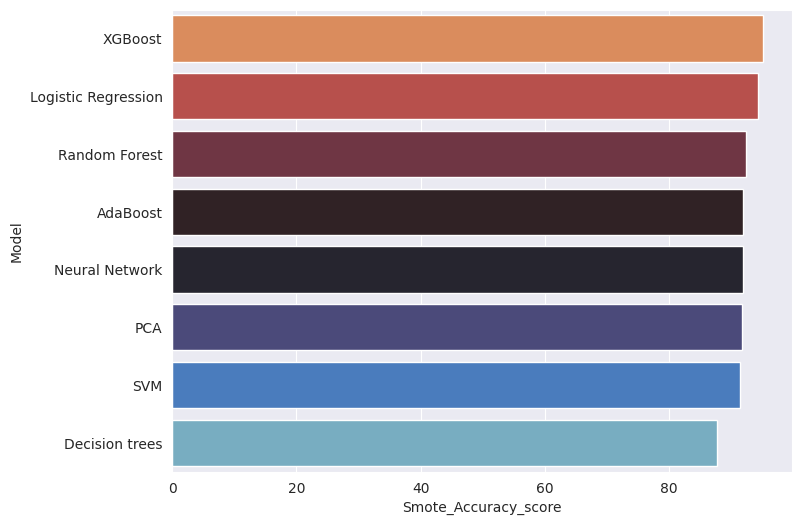

In [83]:
models = pd.DataFrame({
    'Model':['Decision trees', 'Logistic Regression', 'Random Forest', 'PCA', 'AdaBoost', 'SVM',  'XGBoost','Neural Network'],
    'Accuracy_score' : [dt, lr, rf, pca, ada, svm, xgb,nn],
    'Smote_Accuracy_score' : [dt_smote, lr_smote, rf_smote, pca_smote, ada_smote, svm_smote, xgb_smote,nn_smote]
})
sns.barplot(x='Smote_Accuracy_score', y='Model', palette='icefire_r',data=models.sort_values(by='Smote_Accuracy_score',
                                                                         ascending=False, ignore_index=True))

models.sort_values(by='Smote_Accuracy_score', ascending=False, ignore_index=True)

All the models are giving very good performance and their accuracy seems to be very close to each other with XGBoost Leading in terms of performance. After applying SMOTE ENN the models performance jumps up significantly. XGBoost are giving us one of the top model performances. Hence we will be going to use XGBoost as our model for predicting Customer Churn. Lets create a pickle now and store our model in it.

In [84]:
import pickle
# Lets dump our Random Forests model
pickle.dump(model_xgb_smote, open('model.pkl','wb'))

In [85]:
load_model2=pickle.load(open('model.pkl','rb'))
load_model2.score(Xr_test,yr_test)

0.9749498997995992

In [86]:
model_xgb_smote.predict_proba(Xr_test)

array([[9.6249670e-01, 3.7503276e-02],
       [9.9999124e-01, 8.7509015e-06],
       [2.7102232e-04, 9.9972898e-01],
       ...,
       [9.7155571e-04, 9.9902844e-01],
       [3.8051605e-04, 9.9961948e-01],
       [1.2440264e-02, 9.8755974e-01]], dtype=float32)

We can also predict on the entire dataset to calculate the probability of churning by using our model to predict the Churn. After that you can use Power BI to visualize beautiful graphs and bar charts containing all the information in a concise way.


In [87]:
# For Power BI predictions
telco_pred= pd.read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco_pred['TotalCharges']=pd.to_numeric(df_base['TotalCharges'],errors='coerce') #coerce puts NaN values if there are any parsing errors
telco_pred.dropna(inplace=True)
pred=model_xgb_smote.predict_proba(X)[:,1]*100
telco_pred['Predictions']=pred
telco_pred.to_csv('Telco-Churn-Predictions.csv')